In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax.numpy as jnp
from jax import random, vmap, pmap, local_devices
from numpy.polynomial.legendre import leggauss

from models import VAE
from archs import MLP, periodic_encoding
from utils import restore_checkpoint

from configs.default import get_config

import matplotlib.pyplot as plt
# from matplotlib import style
# style.use('dark_background')
%matplotlib inline

print(local_devices())

2023-01-25 16:07:01.331743: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({
                      "text.usetex": True,
                      "font.family": "serif",
                      'text.latex.preamble': r'\usepackage{amsmath}',
                      'font.size': 20,
                      'lines.linewidth': 3,
                      'axes.labelsize': 22,  
                      'axes.titlesize': 24,
                      'xtick.labelsize': 20,
                      'ytick.labelsize': 20,
                      'legend.fontsize': 20,
                      'axes.linewidth': 2})

In [3]:
def legendre_quadrature_1d(n_quad, bounds=(-1.0,1.0)):
    lb, ub = bounds
    # GLL nodes and weights in [-1,1]        
    x, w = leggauss(n_quad)
    # Rescale nodes to [lb,ub]
    x = 0.5*(ub - lb)*(x + 1.0) + lb
    x = jnp.array(x[:,None])
    # Determinant of Jacobian of mapping [lb,ub]-->[-1,1]
    jac_det = 0.5*(ub-lb)
    w = jnp.array(w*jac_det)
    return x, w

def exact_eigenpairs(x, n, alpha=2.0, tau=0.1):
    idx = jnp.arange(n)+1
    evals = jnp.power((2.0 * jnp.pi * idx)**2 + tau**2, -alpha)
    efuns = jnp.sqrt(2.0) * jnp.sin(2.0 * jnp.pi * idx * x)
    return evals, efuns

def sample_u(rng_key, x, n):
    evals, efuns = exact_eigenpairs(x, n)
    xi = random.normal(rng_key, (n,))
    u = jnp.einsum('ij,j->i', efuns, xi*jnp.sqrt(evals))
    w = 1.0/jnp.linalg.norm(u, 2)**2
    return u, x, u[:,None], jnp.tile(w, (x.shape[0],1))


N = 2048
m = 128
neig = 32
bounds = (0.0, 1.0)

x, _ = legendre_quadrature_1d(m, bounds)

# Generate training samples
key = random.PRNGKey(0)
keys = random.split(key, N)
gen_fn = lambda key: sample_u(key, x, neig)
u_train, y_train, s_train, w_train = vmap(gen_fn)(keys)
print('Training data')
print('u: {}'.format(u_train.shape))
print('y: {}'.format(y_train.shape))
print('s: {}'.format(s_train.shape))
print('w: {}'.format(w_train.shape))

# Generate testing samples
key = random.PRNGKey(1)
keys = random.split(key, N)
gen_fn = lambda key: sample_u(key, x, neig)
u_test, y_test, s_test, w_test = vmap(gen_fn)(keys)
print('Testing data')
print('u: {}'.format(u_test.shape))
print('y: {}'.format(y_test.shape))
print('s: {}'.format(s_test.shape))
print('w: {}'.format(w_test.shape))

Training data
u: (2048, 128)
y: (2048, 128, 1)
s: (2048, 128, 1)
w: (2048, 128, 1)
Testing data
u: (2048, 128)
y: (2048, 128, 1)
s: (2048, 128, 1)
w: (2048, 128, 1)


In [4]:
# Load trained model
config = get_config()
model = VAE(config)
model = restore_checkpoint(model, 'eps64_seed2_checkpoint_40000')


                             NeuralOperator Summary                             
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs       ┃ params       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│               │ NeuralOperat… │ -             │ float32[1,1]  │              │
│               │               │ float32[128]  │               │              │
│               │               │ -             │               │              │
│               │               │ float32[1,1]  │               │              │
│               │               │ - float32[64] │               │              │
├───────────────┼───────────────┼───────────────┼───────────────┼──────────────┤
│ encoder       │ MlpEncoder    │ -             │ - float32[64] │              │
│               │               │ float32[128]  │ - float32[]   │              │
│               │          

Relative L2 error: 1.33e-01


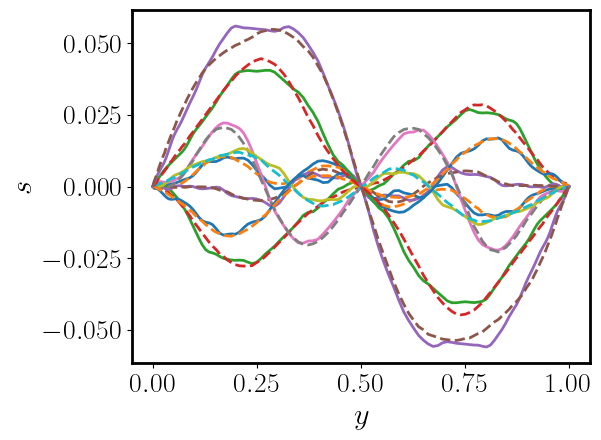

In [5]:
# Test reconstructions
key = random.PRNGKey(123)
eps_test = random.normal(key, (u_test.shape[0], config.eps_dim))
pred_fn = lambda params: model.state.apply_fn(params, u_test, y_test, eps_test)
s_pred = pmap(pred_fn)(model.state.params)[0,...]

error_fn = lambda target, output: jnp.linalg.norm(target-output,2)/jnp.linalg.norm(target,2)
error = vmap(error_fn, in_axes=(0,0))(s_test, s_pred)
print('Relative L2 error: {:.2e}'.format(jnp.mean(error)))

num_samples = 8
plt.figure()
for i in range(num_samples):
    plt.plot(y_test[i,...], s_test[i,...], lw=2)
    plt.plot(y_test[i,...], s_pred[i,...], '--', lw=2)
plt.xlabel('$y$')
plt.ylabel('$s$')
plt.tight_layout()
plt.show()

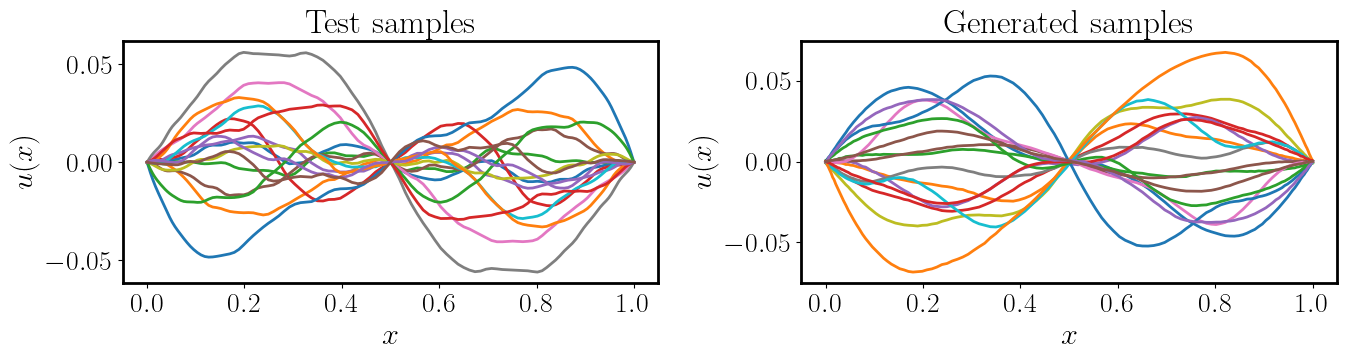

In [8]:
# Generate samples
num_samples = 16
eps_test = random.normal(random.PRNGKey(123), (num_samples, config.eps_dim))
sample_fn = lambda params: model.state.decode_fn(params, eps_test, y_test[:num_samples,...])
samples = pmap(sample_fn)(model.state.params)[0,...]

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
for i in range(num_samples):
    plt.plot(y_test[0,...], s_test[i,...], lw=2)
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.title('Test samples')

plt.subplot(1,2,2)
for i in range(num_samples):
    plt.plot(y_test[0,...], samples[i,...], lw=2)
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.title('Generated samples')

plt.tight_layout()
plt.savefig('generated_samples.png', dpi=300,  bbox_inches='tight')
plt.show()


In [7]:
phi.shape

NameError: name 'phi' is not defined

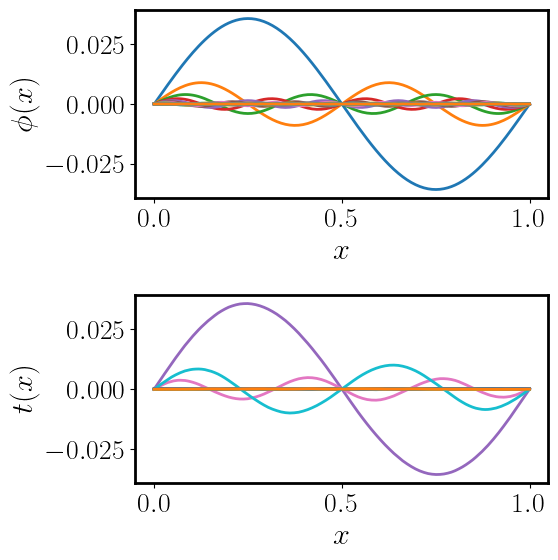

: 

In [10]:
# Visualize trunk functions
if config.decoder_arch.name == 'LinearDecoder':
    trunk = MLP(config.decoder_arch.num_layers,
                config.decoder_arch.hidden_dim,
                config.decoder_arch.output_dim)
    params = {'params': model.state.params['params']['decoder']['MLP_0']}
    inputs = periodic_encoding(y_test[0,...], 1.0)
    pred_fn = lambda params: trunk.apply(params, inputs)
    tau = pmap(pred_fn)(params)[0,...]

    evals, efuns = exact_eigenpairs(x, neig)
    phi = jnp.einsum('ij,jj->ij', efuns, jnp.diag(jnp.sqrt(evals)))
    
    # norm = jnp.linalg.norm(efuns, 2, axis=0)
    # colors = plt.cm(norm)
    # colors = plt.cm.jet(jnp.linspace(phi.min(),phi.max(),neig))

    plt.figure(figsize=(6,6))
    plt.subplot(2,1,1)
    for i in range(neig):
        plt.plot(x, phi[:,i], lw=2)
    plt.xlabel('$x$')
    plt.ylabel('$\phi(x)$')
    plt.subplot(2,1,2)
    for i in range(neig):
        plt.plot(y_test[0,...], tau[:,i], lw=2)
    plt.xlabel('$x$')
    plt.ylabel('$t(x)$')
    plt.tight_layout()
    plt.savefig('eigenfunctions.png', bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
n = config.eps_dim
Nx = m

def compute_covariance_operator(efuncs, evals):
    return evals*1.0/Nx*jnp.tensordot(efuncs, efuncs, axes=0)


def relative_covariance_norm(config, params):
    trunk = MLP(config.decoder_arch.num_layers,
                config.decoder_arch.hidden_dim,
                config.decoder_arch.output_dim)
    params = {'params': params['params']['decoder']['MLP_0']}
    inputs = periodic_encoding(y_test[0,...], 1.0)
    pred_fn = lambda params: trunk.apply(params, inputs)
    tau = pmap(pred_fn)(params)[0,...]

    C = vmap(compute_covariance_operator, in_axes=(1,0))(efuns[:n,:], evals[:n])
    C_hat = vmap(compute_covariance_operator, in_axes=(1,0))(tau, jnp.ones_like(evals))

    C = jnp.sum(C,axis=0)
    C_hat = jnp.sum(C_hat,axis=0)

    diff = C - C_hat
    diff_norm = jnp.linalg.norm(diff,ord='fro') / jnp.linalg.norm(C, ord='fro')

    return diff_norm

In [ ]:
efuns.shape

(128, 32)